In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
# import reference file
enbasedf = pd.read_excel("./letterlang test/ref/letterorderen_full.xlsx")
thbasedf = pd.read_excel("./letterlang test/ref/letterorderth_full.xlsx")

In [3]:
# read and claen the data file from task I (letter language recognition test)
# let the user choose the file

from tkinter import Tk     
from tkinter.filedialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing

username = input("user ID (this will be named in front of every plotted picture):")
datafile = askopenfilename(title="Choose the data file from the experiment, TH mode")
rawth = pd.read_csv(datafile)
datafile = askopenfilename(title="Choose the data file from the experiment, EN mode")
rawen = pd.read_csv(datafile)

In [4]:
# clean data, cut and add the data column into base df
def III_cut_and_clean(basedf, prepdf):
    cutdf = prepdf.iloc[1:97][["lang","langpair","sequence","pairid","key_resp.keys","key_resp.rt"]].reset_index()
    cutdf = cutdf.rename({"key_resp.keys":"key","key_resp.rt":"key_RT"}, axis="columns")
    newdf = basedf
    newdf["key"] = cutdf["key"]
    newdf["key_RT"] = cutdf["key_RT"]
    return newdf

orderth = III_cut_and_clean(thbasedf, rawth)
orderen = III_cut_and_clean(enbasedf, rawen)

In [5]:
#SPECIAL! drop row that contains too high reaction time (as YP think the experiment ended)
orderen = orderen.drop(51)

In [6]:
# assign score for speicific condition

def assign_score(df):
    # Create a boolean mask for 'sequence' and 'key' conditions
    mask_seq_1_z = (df['sequence'] == 1) & (df['key'] == 'z')
    mask_seq_1_x = (df['sequence'] == 1) & (df['key'] == 'x')
    mask_seq_2_z = (df['sequence'] == 2) & (df['key'] == 'z')
    mask_seq_2_x = (df['sequence'] == 2) & (df['key'] == 'x')

    # Assign scores based on conditions
    df['score'] = 0  # Default score
    df.loc[mask_seq_1_z, 'score'] = 1
    df.loc[mask_seq_2_x, 'score'] = 1

In [7]:
assign_score(orderth)
assign_score(orderen)

In [8]:


def I_interpret_lang(df):
    # Define conditions based on 'lang' and 'sequence'
    condition_1 = (df['sequence'] == 1) & (df['lang'] == 1)
    condition_2 = (df['sequence'] == 1) & (df['lang'] == 2)
    condition_3 = (df['sequence'] == 2) & (df['lang'] == 1)
    condition_4 = (df['sequence'] == 2) & (df['lang'] == 2)

    # Use numpy.select to vectorize the mapping logic
    langshow = np.select(
        [condition_1 & (df['langpair'] == 1), condition_1 & (df['langpair'] == 2), condition_1 & (df['langpair'] == 3),
         condition_2 & (df['langpair'] == 1), condition_2 & (df['langpair'] == 2), condition_2 & (df['langpair'] == 3),
         condition_3, condition_4],
        ['english', 'khmer', 'greek', 'thai', 'khmer', 'greek', 'thai', 'english'],
        default='Unknown'
    )

    # Assign the result to the 'langshow' column
    df['langshow'] = langshow




In [9]:
I_interpret_lang(orderen)
I_interpret_lang(orderth)

In [10]:
orderall = pd.concat([orderen, orderth], ignore_index=True)

In [11]:
print("score of Thai letter discrimination:",orderth['score'].sum(),"out of",orderth.shape[0],"!")
print("score of English letter discrimination:",orderen['score'].sum(),"out of",orderen.shape[0],"!")

score of Thai letter discrimination: 96 out of 96 !
score of English letter discrimination: 95 out of 95 !


# Plof boxplot and histogram of reaction time based on language

In [12]:
redgradient = ["#ffa5bb","#ff9eb6", "#ff7d9d", "#ff6087","#ff0040" ] # thai language, use the last index value as the main color
bluegradient = ["#c0d7ff", "#92bcff", "#5e9eff","#3686ff","#0067ff" ] # english language, use the last index value as the main color
gaygradient = ["#949494", '#727272', '#4b4b4b', '#484848', '#373737'] # overall gradient
colincorrect = '#ff6962'
colcorrect  = '#77dd76'

In [13]:
def I_plot_histogram_and_boxplot(df, lang, title, ylim,  savedir):
    
    # Calculate the number of bins
    bin_count = 25
    
    # Create a figure with two subplots: one for histogram and one for boxplot
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})
    
    # Plot boxplot above histogram
    sns.boxplot(data=df, x='key_RT', ax=ax[0], color='lightgray', width=0.3)
    ax[0].set_title(title)
    ax[0].set_xlabel('')
    ax[0].set_xlim(0,2.5)

    # Plot histogram below boxplot with the Freedman-Diaconis rule bin count
    # change color depending on language input
    colorlang = bluegradient[4] if lang == 'th' else redgradient[4] if lang == 'en' else gaygradient[2]
    ax[1].hist(df['key_RT'], bins=bin_count,range = (0,2.5), edgecolor='black', color = colorlang)
    ax[1].set_title('')
    ax[1].set_xlabel('reaction time (s)')
    ax[1].set_ylabel('Frequency')
    ax[1].grid(False)
    ax[1].set_xlim(0,2.5)
    ax[1].set_ylim(0,ylim)

    # Show the plot
    plt.tight_layout()
    plt.savefig(savedir)
    plt.close()

In [14]:
I_plot_histogram_and_boxplot(orderth, "th", "boxplot and histogram of reaction time: Thai letter discrimination", 30, f"./figure/{username} I hist TH.png")
I_plot_histogram_and_boxplot(orderen, "en", "boxplot and histogram of reaction time: English letter discrimination",30, f"./figure/{username} I hist EN.png")
I_plot_histogram_and_boxplot(orderall, "all", "boxplot and histogram of reaction time: Thai and English letter discrimination",60, f"./figure/{username} I hist all.png")

# reaction time by letter language
⚠⚠⚠⚠⚠⚠caution: each letter has different data point (main language = 24 ,other = 8)⚠⚠⚠⚠⚠⚠

In [15]:
def I_plot_mean_reaction_time(df, savefig_dir=None, plot_title='Mean Reaction Time by Language'):
    # Define the custom order for 'langshow'
    custom_order = ["thai", "english", "khmer", "greek"]
    df['langshow'] = pd.Categorical(df['langshow'], categories=custom_order, ordered=True)

    # Group by 'langshow' and calculate the mean and standard error of 'key_RT'
    grouped = df.groupby('langshow', observed=True)['key_RT']
    mean_rt = grouped.mean()
    sem_rt = grouped.sem()  # Standard Error of the Mean

    # Create a DataFrame for plotting
    plot_data = mean_rt.reset_index()
    plot_data['sem'] = sem_rt.values

    # Reorder the DataFrame based on the custom order
    ordered_data = plot_data.set_index('langshow').loc[custom_order].reset_index()
    ordered_data = ordered_data.dropna(subset=['key_RT', 'sem'])

    # Define x positions
    x = np.arange(len(custom_order))

    # Define custom colors
    colors = [bluegradient[4],redgradient[4], '#80ef80', '#fdfd96']

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot bars
    bars = ax.bar(x, ordered_data['key_RT'], yerr=ordered_data['sem'], 
                  capsize=5, color=colors, edgecolor='black', width = 0.5)

    # Add mean values on top of bars
    for i, (bar, mean, sem) in enumerate(zip(bars, ordered_data['key_RT'], ordered_data['sem'])):
        ax.text(bar.get_x() + bar.get_width()/2, mean + sem * 1.5, f'{mean:.2f}', 
                ha='center', va='bottom', color='black', fontweight='light', fontsize=10)

    # Set labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(custom_order)
    ax.set_ylabel('Mean Reaction Time (s)')
    ax.set_xlabel('Language')
    ax.set_title(plot_title)

    # Set y-axis limits
    plt.ylim(0, 1)

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a directory is provided
    if savefig_dir:
        plt.savefig(savefig_dir, bbox_inches='tight')
        print(f"Plot saved to {savefig_dir}")

    plt.show()
    

Plot saved to ./figure/YP I RT by lang all.png


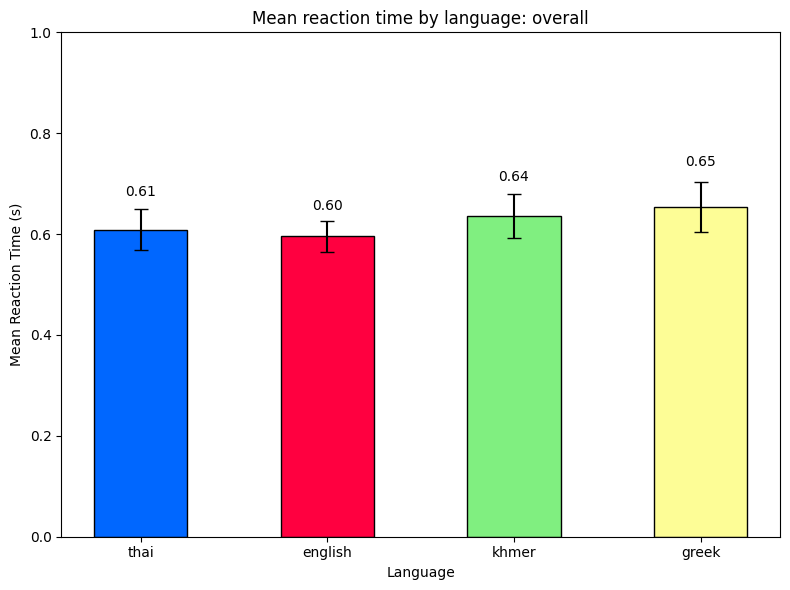

Plot saved to ./figure/YP I RT by lang EN.png


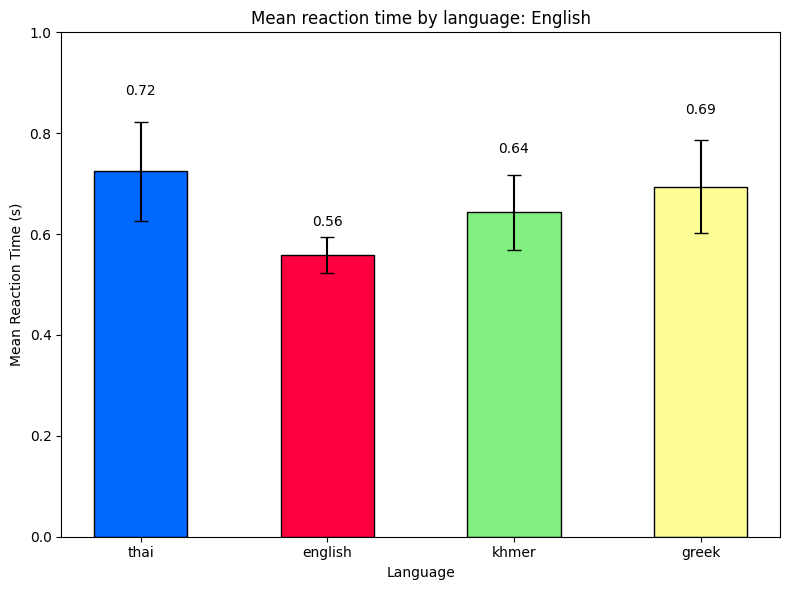

Plot saved to ./figure/YP I RT by lang TH.png


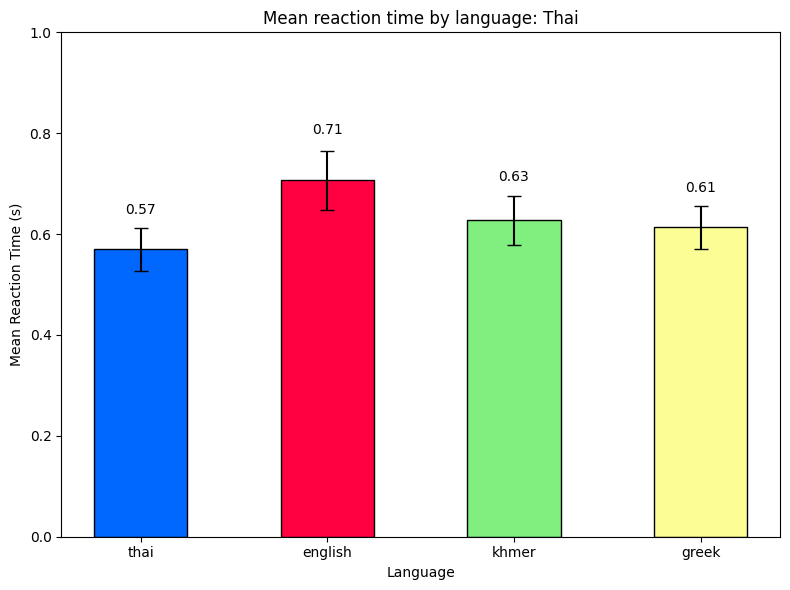

In [16]:
I_plot_mean_reaction_time(orderall,f"./figure/{username} I RT by lang all.png", "Mean reaction time by language: overall")
I_plot_mean_reaction_time(orderen,f"./figure/{username} I RT by lang EN.png", "Mean reaction time by language: English")
I_plot_mean_reaction_time(orderth,f"./figure/{username} I RT by lang TH.png", "Mean reaction time by language: Thai")

In [17]:
from matplotlib.patches import Patch
def I_plot_grouped_reaction_time(data1, data2, lang_order=None,group_names=('Group 1', 'Group 2'), plot_title=None, save_path=None):
    
    # Aggregate data using pandas
    def process_df(df):
        return df.groupby('langshow', observed=True).agg(
            mean_RT=('key_RT', np.nanmean),
            sem_RT=('key_RT', lambda x: np.nanstd(x)/np.sqrt(len(x)))
        ).reindex(lang_order)

    agg1, agg2 = process_df(data1), process_df(data2)
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(lang_order))  # label locations
    width = 0.35  # bar width
    
    engcol = ["#3077ff", "#ff2055", "#a0f080", "#fdec90"]

    thaicol = ["#66a8ff", "#ff7b8e", "#c3f5a3", "#fef0b3"]

    # Create grouped bars
    bars1 = ax.bar(x - width/2, agg1['mean_RT'], width, yerr=agg1['sem_RT'], color = thaicol, label=group_names[0], capsize=5, edgecolor = "black")
    bars2 = ax.bar(x + width/2, agg2['mean_RT'], width, yerr=agg2['sem_RT'], color = engcol, label=group_names[1], capsize=5, edgecolor = "black", hatch = '..')
    
    # Add labels and formatting
    ax.set_ylabel('Reaction Time (s)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(lang_order, fontsize=11)
    legend_elements = [Patch(facecolor='white', edgecolor='black', label='Thai'),
        Patch(facecolor='white', edgecolor='black', hatch = '..', label='English')]
    ax.legend(frameon=False, fontsize=10, handles=legend_elements)
    
    
    # Add value labels using list comprehension
    for rect, values in zip([bars1, bars2], [agg1, agg2]):
        for idx, bar in enumerate(rect):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., 
                    height + values['sem_RT'].iloc[idx] + 0.01,
                    f'{height:.2f}', 
                    ha='center', va='bottom', fontsize=9)
    
    plt.ylim(0,1)
    plt.xlabel("Language")
    if plot_title:
        plt.title(plot_title, pad=20, fontsize=14)
    
    if save_path:

        plt.savefig(save_path, bbox_inches='tight', dpi=300, 
                   facecolor='white')
    
    plt.show()

C:\Users\UserPC\AppData\Local\Temp\ipykernel_12056\2200518399.py:6: FutureWarning: The provided callable <function nanmean at 0x0000022B49080310> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return df.groupby('langshow', observed=True).agg(
C:\Users\UserPC\AppData\Local\Temp\ipykernel_12056\2200518399.py:6: FutureWarning: The provided callable <function nanmean at 0x0000022B49080310> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return df.groupby('langshow', observed=True).agg(


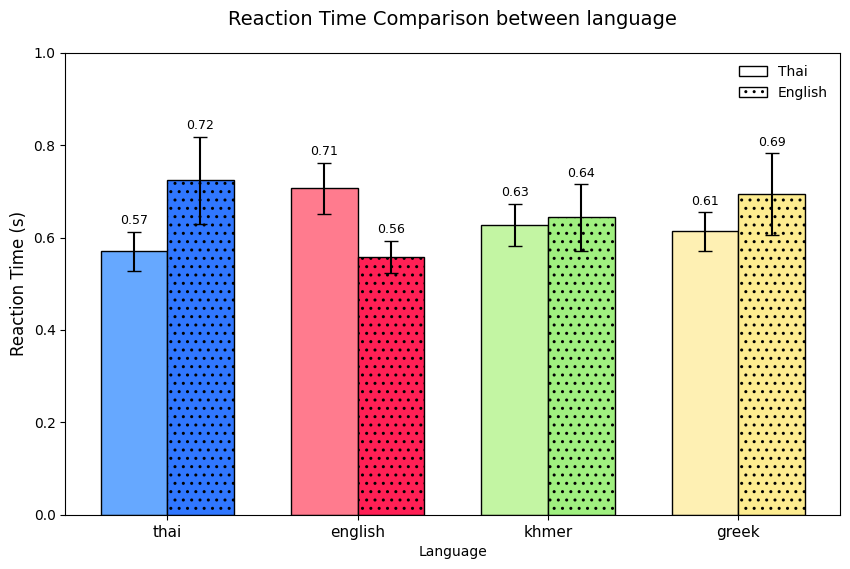

In [18]:
I_plot_grouped_reaction_time(
    orderth, orderen,
    lang_order=['thai', 'english', 'khmer', 'greek'],
    group_names=('Thai', 'English'),
    plot_title='Reaction Time Comparison between language',
    save_path=f'./figure/{username} I RT by lang grouped.png'
)